## Problem 7.2: MCMC with Boolean data (40 pts)

In [Homework 6](hw6.html), you investigated a data set on reversals of optogenetic worms upon exposure to blue light. As a reminder, here are the data.

|Strain|Year|Trials|Reversals|
|:---:|:---:|:---:|:---:|
|WT|2017|55|7|
|ASH|2017|54|18|
|AVA|2017|52|28|
|WT|2016|36|6|
|ASH|2016|35|12|
|AVA|2016|36|30|
|WT|2015|35|0|
|ASH|2015|35|9|
|AVA|2015|36|33|

Again, for the purposes of this problem, assume that we can pool the results from the two years to have 13/126 reversals for wild type, 39/124 reversals for ASH, and 91/124 reversals for AVA.

The pertinent parameter is $\theta$, the probability of reversal of a worm upon illumination.

**a)** Use Stan to get samples of $\theta$ for each of the three strains. Plot either histograms or ECDFs of your samples.



In [51]:
import numpy as np
import pandas as pd
import numba
import scipy.stats as st
# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

**b)** Use your Metropolis-Hastings sampler from the previous problem to do the same.


In [52]:
def mh_step(x, logpost, logpost_current, sigma, args=()):
    """
    Parameters
    ----------
    x : ndarray, shape (n_variables,)
        The present location of the walker in parameter space.
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    logpost_current : float
        The current value of the log posterior.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `logpost()` function.

    Returns
    -------
    output : ndarray, shape (n_variables,)
        The position of the walker after the Metropolis-Hastings
        step. If no step is taken, returns the inputted `x`.
    """
    # Turn sigma into a diagonal matrix so that it can be used as
    # the covariance matrix for numpy's multivariate guassian function
    cov = np.diag(sigma * sigma) # squared because variance is std. squared
    
    # Now I will choose the next step, x-prime
    xp = np.random.multivariate_normal(x, cov, 1)[0]
    
    # Compute the log-posterior at x-prime
    logpost_xp = logpost(xp, *args)
    
    # Calculate metropolis ratio
    r = np.exp(logpost_xp - logpost_current)
    
    if (r >= 1):
        return xp
    elif(np.random.rand() < r):
        return xp
    else:
        return x

In [8]:
def mh_sample(logpost, x0, sigma, args=(), n_burn=1000, n_steps=1000,
              variable_names=None):
    """
    Parameters
    ----------
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `logpost()` function.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    variable_names : list, length n_variables
        List of names of variables. If None, then variable names
        are sequential integers.
    
    Returns
    -------
    output : DataFrame
        The first `n_variables` columns contain the samples.
        Additionally, column 'lnprob' has the log posterior value
        at each sample.
    """
    
    # Define variable names
    if variable_names == None:
        variable_names = list(range(len(x0)))
    
    # Define starting points
    x = x0
    logpost_current = logpost(x, *args)
        
    # Burn step    
    for c in range(n_burn):
        x = mh_step(x, logpost, logpost_current, sigma, args=args)
        logpost_current = logpost(x, *args)
    
    
    # Make arrays to take data
    samples = [0]*n_steps
    logpost_values = np.empty([len(range(n_steps))])
    
    # Do the sampling
    for k in range(n_steps):
        x = mh_step(x, logpost, logpost_current, sigma, args=args)
        logpost_current = logpost(x, *args)
        samples[k] = x
        logpost_values[k] = logpost_current
        
    
    # Convert arrays to dataframe    
    df =  pd.DataFrame(data=samples, columns = variable_names)
    df["lnprob"] = logpost_values
        
        
    return df

In [104]:
def calc_acceptance_rate(output_df):
    """Determines the acceptance rate of an MCMC sampler within the passed
    dataframe containing MCMC samples. """
    num_rejections = 0
    last_row = np.zeros(len(output_df.loc[0].values))
    for row in output_df.iterrows():
        row = row[1].values
        if (row == last_row).all():
            num_rejections += 1
        last_row = row
    return (len(output_df.index) - num_rejections) / len(output_df.index)

In [105]:
def find_std_dev_correction(acceptance_rate):
    """Returns the necessary multiplicative correction to the standard deviation
    of the proposal distribution given an acceptance rate for the metropolis-
    hastings MCMC sampler. """
    if acceptance_rate < .001:
        return 0.1
    elif acceptance_rate < 0.05:
        return 0.5
    elif acceptance_rate < 0.2:
        return 0.9
    elif acceptance_rate < 0.5:
        return 1
    elif acceptance_rate < 0.75:
        return 1.1
    elif acceptance_rate < 0.95:
        return 2
    else:
        return 10

In [106]:
def mh_sample_optimize_acceptance(logpost, 
                                  x0, 
                                  sigma, 
                                  args=(), 
                                  n_burn=1000, 
                                  n_steps=1000, 
                                  n_opt_acc = 1000,
                                  variable_names=None):
    """New sampling function that includes optimization of sigma
    with respect to the acceptance rate. n_opt_acc indicates the number
    of steps that should be used to optimize, but all other parameters
    are identical to those used in mh_sample()"""
    
    # Define variable names
    if variable_names == None:
        variable_names = list(range(len(x0)))
    
    # Define starting points
    x = x0
    logpost_current = logpost(x, *args)
        
    # Burn step    
    for c in range(n_burn):
        x = mh_step(x, logpost, logpost_current, sigma, args=args)
        logpost_current = logpost(x, *args)
    
    # Starting optimization!!
    iterations = 0
    while(True):
        # Make arrays to take optimization data
        samples_opt = [0]*n_opt_acc
        logpost_values_opt = np.empty([len(range(n_opt_acc))])

        # Do the sampling
        for k in range(n_opt_acc):
            x = mh_step(x, logpost, logpost_current, sigma, args=args)
            logpost_current = logpost(x, *args)
            samples_opt[k] = x
            logpost_values_opt[k] = logpost_current

        # Convert arrays to dataframe    
        df_opt =  pd.DataFrame(data=samples_opt, columns = variable_names)
        df_opt["lnprob"] = logpost_values_opt
        
        # Calculate acceptance rate and optimize sigma
        rate = calc_acceptance_rate(df_opt)
        opt_factor = find_std_dev_correction(rate)
        sigma *= opt_factor
        
        # If the acceptance rate was way off, repeat this process again. 
        # Otherwise, we can exit the loop
        if (opt_factor == 1):
            break
            
        # This program has the potential for an infinite loop. I don't want
        # this to happen, so if this iterates 10 times I'll print a warning
        # statement and stop optimizing. 
        iterations += 1
        if iterations >= 10:
            print("WARNING: Acceptance rate did not converge!")
            break
    
    # Make arrays to take data
    samples = [0]*n_steps
    logpost_values = np.empty([len(range(n_steps))])
    
    # Do the sampling
    for k in range(n_steps):
        x = mh_step(x, logpost, logpost_current, sigma, args=args)
        logpost_current = logpost(x, *args)
        samples[k] = x
        logpost_values[k] = logpost_current
        
    
    # Convert arrays to dataframe    
    df =  pd.DataFrame(data=samples, columns = variable_names)
    df["lnprob"] = logpost_values

    return df

In [107]:
# arrays for alpha and beta values for our three strains
a_array = [1, 2, 5]
b_array = [8, 7, 6]

# arrays for the datapoints we have for number of reversals for our three strains
n_array = [13, 39, 91]
N_array = [126, 124, 124]
# array for the names of the conditions
name_array = ['WT', 'ASH', 'AVA']

In [108]:
def log_post_reversal(x, a, b, n, N):
    
    log_prior = st.beta.logpdf(x, a, b)

    # The log_likelihood is just the binomial distribution
    log_like = np.sum(st.binom.logpmf(n, N, x))

    return log_prior + log_like

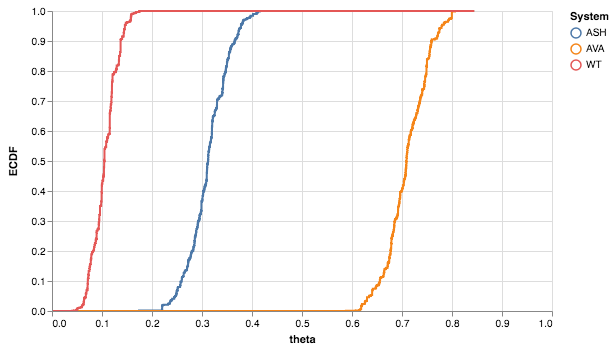

In [110]:
# Initial guess for MCMC
x_0 =np.array([1])
# Standard Deviations for proposal dist.
s = np.array([1.])

for i in range(3):
    df_mcmc_temp = mh_sample_optimize_acceptance(log_post_reversal, 
                         x_0, 
                         s, 
                         args = (a_array[i], b_array[i], n_array[i], N_array[i]),
                         n_steps=1000,
                         variable_names = ["theta"])
    df_mcmc_temp["Condition"] = name_array[i]
    if i == 0:
        df_mcmc_total = df_mcmc_temp
    else:
        df_mcmc_total = pd.concat([df_mcmc_total, df_mcmc_temp])

altcat.catplot(data=df_mcmc_total,
               mark='line',
               encoding=dict(x=alt.X('theta:Q',
                                     scale=alt.Scale(
                                     domain=(0, 1),
                                     clamp=True)),
                            color = alt.Color('Condition:N', title='System')),
               transform='ecdf'
              ).properties(height=300,
                           width=500)

**c)** The posterior plots of $\theta$ are illuminating, but suppose we want to quantify *the difference* in reversal probability between the two strains, say strain 1 and strain 2. That is, we want to compute $g(\delta_{12}\mid n_1, N_1, n_2, N_2)$, where $\delta_{12} \equiv \theta_2 - \theta_1$. Note that computing this distribution by hand is quite difficult.

To quantify this difference we can simply take the difference between the two distributions.

In [78]:
# Initial guess for MCMC
x_0 =np.array([1])
# Standard Deviations for proposal dist.
s = np.array([1])

for i in range(3):
    df_mcmc_temp = mh_sample(log_post_reversal, 
                         x_0, 
                         s, 
                         args = (a_array[i], b_array[i], n_array[i], N_array[i]),
                         n_steps=5000,
                         variable_names = [name_array[i]])
    if i == 0:
        df_mcmc_total2 = df_mcmc_temp
    else:
        df_mcmc_total2[name_array[i]] = df_mcmc_temp[name_array[i]]

In [79]:
df_mcmc_total2.head()

,WT,lnprob,ASH,AVA
0,0.137141,-1.769843,0.185213,0.715651
1,0.137141,-1.769843,0.185213,0.715651
2,0.137141,-1.769843,0.185213,0.715651
3,0.137141,-1.769843,0.185213,0.715651
4,0.137141,-1.769843,0.185213,0.715651


In [80]:
df_mcmc_total2["ASHWT"]= df_mcmc_total2["ASH"] - df_mcmc_total2["WT"]
df_mcmc_total2["AVAWT"]= df_mcmc_total2["AVA"] - df_mcmc_total2["WT"]
df_mcmc_total2["AVAASH"]= df_mcmc_total2["AVA"] - df_mcmc_total2["ASH"]

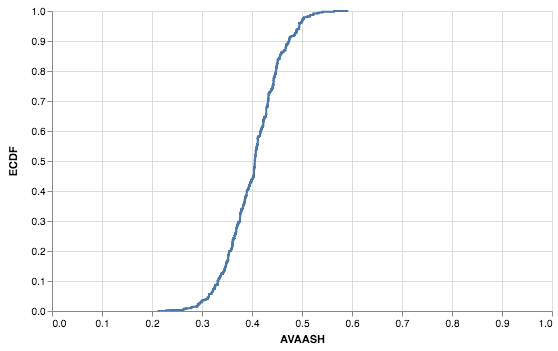

In [85]:
altcat.catplot(data=df_mcmc_total2,
               mark='line',
               encoding=dict(x=alt.X('AVAASH:Q',
                                     scale=alt.Scale(
                                     domain=(0, 1),
                                     clamp=True)),
                            color),
               transform='ecdf'
              ).properties(height=300,
                           width=500)